In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to C:\Users\Ayush
[nltk_data]     Yadav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
emails = pd.read_csv('emails.csv')

emails.head()


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
emails.shape

(5728, 2)

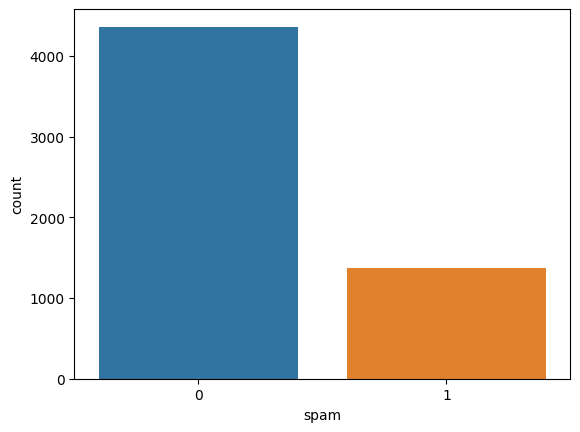

In [5]:
sns.countplot(x='spam', data=emails)
plt.show()


Text(0.5, 0, 'Message types')

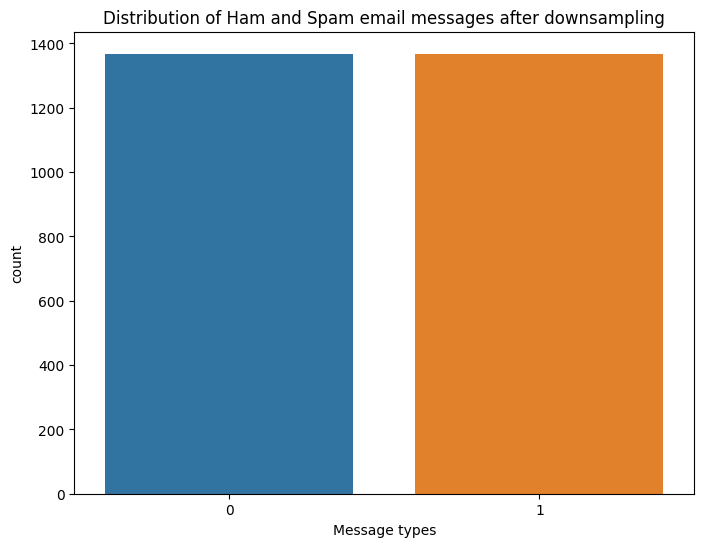

In [6]:
# Downsampling to balance the dataset
ham_msg = emails[emails.spam == 0]
spam_msg = emails[emails.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
						random_state=24)

# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg)\
	.reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


In [7]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()


,text,spam
0,": re : interview rahul , i shall be glad to ...",0
1,": hea sporting clays tourney - august 15 , 200...",0
2,": school teaching hello vince , i stopped by...",0
3,: fyi,0
4,: fyi : sycamore support on network planning ...,0


In [8]:
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()


,text,spam
0,re interview rahul i shall be glad to mee...,0
1,hea sporting clays tourney august 15 2000 ...,0
2,school teaching hello vince i stopped by t...,0
3,fyi,0
4,fyi sycamore support on network planning fy...,0


In [9]:
balanced_data.shape

(2736, 2)

In [11]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,text,spam
0,interview rahul shall glad meet please give ca...,0
1,hea sporting clays tourney august 15 2000 memb...,0
2,school teaching hello vince stopped see today ...,0
3,fyi,0
4,fyi sycamore support network planning fyi note...,0


In [12]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
													balanced_data['spam'],
													test_size = 0.2,
													random_state = 42)


In [14]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')
#print(tokenizer)


In [15]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           814016    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 817,729
Trainable params: 817,729
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')


In [17]:
es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


In [18]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=25,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/25
69/69 [==============================] - 5s 38ms/step - loss: 0.6147 - accuracy: 0.6668 - val_loss: 0.2251 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 2s 33ms/step - loss: 0.1604 - accuracy: 0.9625 - val_loss: 0.1775 - val_accuracy: 0.9562 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 2s 32ms/step - loss: 0.1163 - accuracy: 0.9739 - val_loss: 0.1689 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 2s 33ms/step - loss: 0.0940 - accuracy: 0.9799 - val_loss: 0.1838 - val_accuracy: 0.9562 - lr: 0.0010


In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)


18/18 [==============================] - 0s 6ms/step - loss: 0.2251 - accuracy: 0.9708
Test Loss : 0.22506405413150787
Test Accuracy : 0.970802903175354


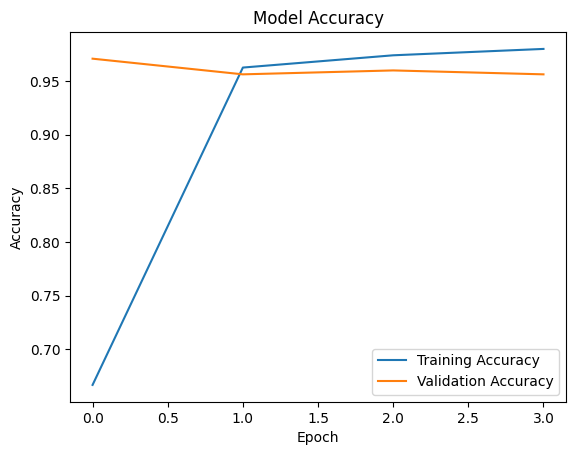

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [25]:
model.save("spam_classifier.h5")